# Zeevaert's modal analysis to calculate seismic-induced $\tau$ and $\delta$ in stratified soil
© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_dynamics/blob/main/notebooks/zeevaert_modal_analysis.ipynb).

The content of this notebook was developed based on [L. Zeevaert (1973)](<https://doi.org/10.1016/0148-9062(76)91911-2>).

## Required modules and global setup for plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, widgets, fixed
from IPython import get_ipython
from IPython.display import display, clear_output

if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()
    %pip install ipympl &> ~/pip-log.txt

%matplotlib widget

mpl.rcParams.update(
    {
        # 'figure.dpi': 300,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

In [2]:
def modal_analysis(ground_acel, period_n, depth, unit_weigth, shear_modulus,
                   stress_units="kN", plot_strata=False):
    # inputs to arrays
    density = np.array(unit_weigth) / 9.8
    shear_modulus = np.array(shear_modulus)
    depth = np.array([0] + depth)  # Include surface level
    thickness = np.diff(depth)
    frequency_n = 2 * np.pi / np.array(period_n)  # [rad/s]
    # Modal analysis
    delta_n = []
    tau_n = []
    for ω in frequency_n:
        # Coefficients to calculate τ and δ
        N = density * thickness**2 * ω**2 / (4 * shear_modulus)
        A = (1 - N) / (1 + N)
        B = thickness / ((1 + N) * shear_modulus)
        C = 0.5 * density * thickness * ω**2
        # Calculation of τ and δ
        τ = [0]  # τ at ground surfac
        δ = [ground_acel / ω**2]  # δ at ground surface
        for i in range(len(thickness)):
            δ.append(A[i] * δ[i] - B[i] * τ[i])
            τ.append(τ[-1] + C[i] * (δ[i] + δ[i-1]))
        delta_n.append(δ)
        tau_n.append(τ)

    # Plot
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=[6.5, 4], sharey=True)
    if plot_strata:
        for d in depth:
            for ax in axs:
                ax.axhline(d, color='k', ls="-", lw=.5)
    for i in range(len(frequency_n)):
        axs[0].plot(delta_n[i], depth)
        axs[1].plot(tau_n[i], depth, label=f"T$_{i + 1}$" + f"={period_n[i]:.2f} s")
    
    [format_axes(ax) for ax in axs]
    axs[0].invert_yaxis()
    axs[0].set(xlabel="Displacement, $\delta$  [m]", ylabel="Depth, $z$  [m]")
    axs[1].set(xlabel="Shear stress, $\\tau$  ["+f"{stress_units}"+"/m$^2$]")
    axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.show()
    return

def format_axes(ax):
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["top"].set_linewidth(1.5)
    ax.grid(True, which="major", color="gray", linestyle=":")
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlim(-np.abs(ax.get_xlim()).max(), np.abs(ax.get_xlim()).max())


## Example of central part of Mexico City (Alameda Park)

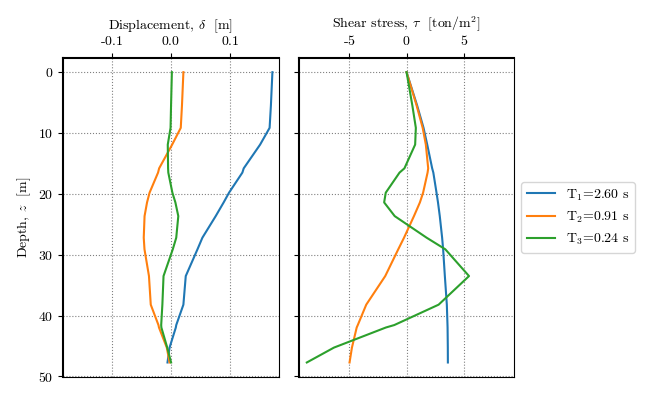

In [3]:
ground_acel = 1  # [m/s²]
period_n = [2.6, 0.91, 0.245]  # [s]
depth = [5.5, 9.15, 11.9, 15.8, 16.5, 19.8, 21.4, 23.65, 27.2, 29.1, 33.5, 38.2, 41.55, 41.95, 45.25, 47.7]  # [m]
unit_weigth = [1.66, 1.5, 1.17, 1.17, 1.77, 1.16, 1.24, 1.24, 1.18, 1.2, 1.17, 1.77, 1.27, 1.75, 1.25, 1.28]  # [ton/m³]
shear_modulus = [1000, 2000, 280, 280, 700, 360, 470, 470, 470, 720, 720, 4000, 980, 2000, 1120, 2500]  # [ton/m²]

modal_analysis(ground_acel, period_n, depth, unit_weigth, shear_modulus, stress_units="ton")